# Import Data

In [18]:
import pickle
import os
import pandas as pd
from collections import Counter
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
from extraction import *
from manualValidation import *

# Import the data

```pickle file of the extracted nominal phrases ```

In [19]:
pickle_path_3m_nounPhrase = "./3m_nounPhrase.pkl"
path_dir = '/home/ywang78/scratch/conllu/leipzig_conllu/'
if not os.path.exists(pickle_path_3m_nounPhrase):
    list_file_paths = [path_dir+file for file in os.listdir(path_dir)]
    nounPhraseP(list_file_paths).to_pickle('./3m_nounPhrase.pkl')
else:
    df = pd.read_pickle(pickle_path_3m_nounPhrase)

In [20]:
print('the number of unique parsed classifiers is {}.'.format(len(df.clf_form.unique())))
print('the shape of the dataframe is {}.'.format(df.shape))
print('the number of non classifiers determined by human is {}.'.format(len(not_clf))) # 1377

the number of unique parsed classifiers is 1577.
the shape of the dataframe is (1079190, 10).
the number of non classifiers determined by human is 1377.


# Preprocess: 
## check on the length of nominal phrases

In [ ]:
df['phrase_len'] = df['phrase'].str.count(pat='[\u4e00-\u9fff]')
# df.sort_values(by='phrase_len',ascending=True).phrase_len.describe() 

In [ ]:
# df[df['phrase_len']<25]['phrase_len'].plot.hist()
# df[df['phrase_len']>25]['phrase_len'].plot.hist()
# df[df['phrase_len']>=35].shape

In [ ]:
# remove nominal phrases which are equal or longer than 35 character.
df = df[df['phrase_len']<35]

# Preprocess:
## manual validate the parsed classifiers

In [7]:
# the list of clfs that pass through the validation
clf_ls = [item for item in list(df.clf_form.unique()) if item not in not_clf]
print('{} of classifiers that are validated as classifiers.'.format(len(clf_ls)))

315 of classifiers that are validated as classifiers.


In [8]:
# reduce the size of dataframe and based on the validated classifiers
df = df.loc[df['clf_form'].isin (clf_ls)]
print(df.shape)
print('the number of unique nominal phrases is {}'.format(len(df['phrase'].unique()))) 
print('the number of unique classifiers is {}'.format(len(df.clf_form.unique())))
print('the number of unique nouns is {}'.format(len(df.clf_gov2_form.unique())))

# the result of the dataframe is saved to './cleaned_data.csv'

(981076, 11)
the number of unique nominal phrases is 510441
the number of unique classifiers is 315
the number of unique nouns is 45159


# Preprocess:
## prepare for extracting word embedding from a BERT model (Distribution)

In [9]:
# categorize classifiers into different groups based on manual validation
df['label1'] = df.apply(man_label1,axis=1)
df['label2'] = df.apply(man_label2,axis=1)
df['clf_len'] = df['clf_form'].str.count(pat='[\u4e00-\u9fff]')

In [10]:
# the distribution of the number of characters among different types of classifiers 
df.groupby(by=['label2','clf_len']).count()['clf_form']

label2             clf_len
currency           1              19
                   2            2758
measurement        1           16428
                   2            2789
                   3             579
                   4             210
quantity           1          420989
                   2            6044
sortal_classifier  1          531260
Name: clf_form, dtype: int64

In [11]:
# Remove phrase of which classifier is multi-token units
df1 = df[df['clf_form'].apply(len)==1]

# the dataframe containing the unique nominal phrases
df1 = df1.drop_duplicates(subset='phrase', keep="first")
print('the number of unique nominal phrases is {}.'.format(df1.shape[0]))
print('the number of unique classifiers is {}.'.format(len(df1.clf_form.unique())))

the number of unique nominal phrases is 500988.
the number of unique classifiers is 222.


# Distribution

``` load the file of dimensional-reduced (UMAP) word_embeddings (BERT)```

In [12]:
df_emb1 = pd.read_pickle('./clf_emb_bert_umap1.pkl')
df_emb1.rename(columns={"label": "clf_form"},inplace=True)
df_emb1['label1'] = df_emb1.apply(man_label1,axis=1)
df_emb1['label2'] = df_emb1.apply(man_label2,axis=1)

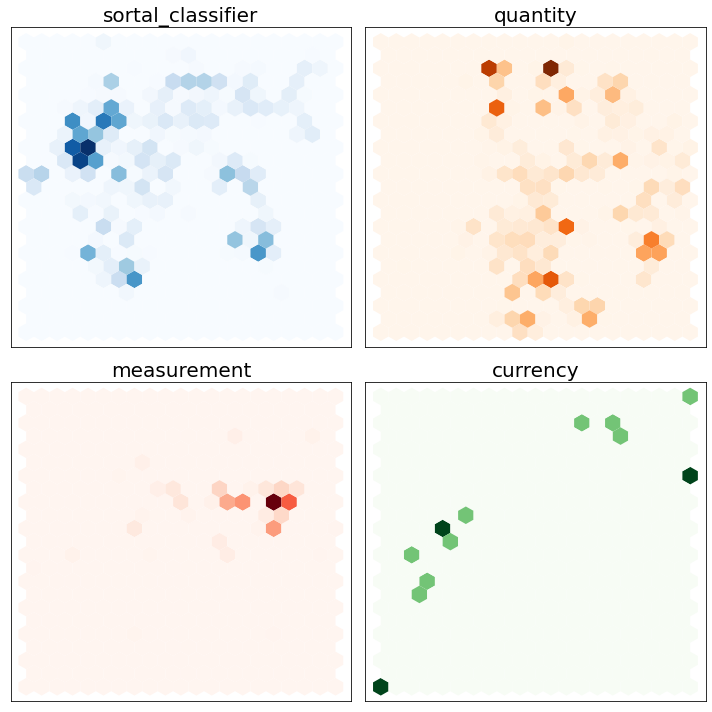

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
cmaps = ['Blues', 'Oranges','Reds','Greens']
labels = ['sortal_classifier','quantity','measurement','currency']

for i,(label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb1[df_emb1['label2'] == label]
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label,fontdict={'fontsize':20})
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Function

```load the noun counter of the corpora```

In [14]:
with open('./leipzig.noun.pkl', 'rb') as f:
        noun_counter= pickle.load(f)

In [15]:
noun_entropy = calculate_entropy(noun_counter)
print("Noun's entropy is {}.".format(round(noun_entropy,2)))

Noun's entropy is 12.29.


In [16]:
noun_clf_counter = {}
for clf in list(df['clf_form'].unique()):
    noun_clf_counter[clf] = Counter(df[df['clf_form']==clf].clf_gov2_form)
print('The mutual information between noun and classifier is {}.'.format(round(mutual_information(noun_counter,noun_clf_counter),2)))

The mutual information between noun and classifier is 7.57.


In [19]:
cond_n_exact_clf = calculate_conditional_entropy(noun_clf_counter)
df_cond = pd.DataFrame.from_dict(cond_n_exact_clf,orient='index')
df_cond.reset_index(inplace=True)
df_cond = df_cond.rename(columns={"index": "clf_form", 0: "cond_entro"})

df_cond['label1'] = df_cond.apply(man_label1,axis=1)
df_cond['label2'] = df_cond.apply(man_label2,axis=1)
df_cond['entropy_n'] = noun_entropy
df_cond['mi'] = df_cond['entropy_n'] - df_cond['cond_entro']

## ANOVA

In [20]:
model = ols('mi ~ C(label2)', data=df_cond).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(label2),380.122537,3.0,25.460721,9.351143e-15
Residual,1547.718792,311.0,NaN,NaN


In [21]:
tukey_test = pairwise_tukeyhsd(df_cond["mi"], df_cond["label2"])
tukey_test._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
currency,measurement,-0.2696,0.9492,-1.5592,1.02,False
currency,quantity,-2.1259,0.0001,-3.3512,-0.9006,True
currency,sortal_classifier,-3.0798,0.0,-4.4512,-1.7084,True
measurement,quantity,-1.8563,0.0,-2.6376,-1.075,True
measurement,sortal_classifier,-2.8102,0.0,-3.8051,-1.8154,True
quantity,sortal_classifier,-0.954,0.0358,-1.8639,-0.044,True


## Visualization

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

quantity v.s. measurement: t-test independent samples with Bonferroni correction, P_val=1.546e-07 stat=-5.766e+00
sortal_classifier v.s. quantity: t-test independent samples with Bonferroni correction, P_val=3.325e-02 stat=-2.804e+00
measurement v.s. currency: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-5.095e-01
quantity v.s. currency: t-test independent samples with Bonferroni correction, P_val=1.665e-04 stat=-4.307e+00
sortal_classifier v.s. measurement: t-test independent samples with Bonferroni correction, P_val=1.376e-11 stat=-7.701e+00
sortal_classifier v.s. currency: t-test independent samples with Bonferroni correction, P_val=6.724e-10 stat=-7.429e+00


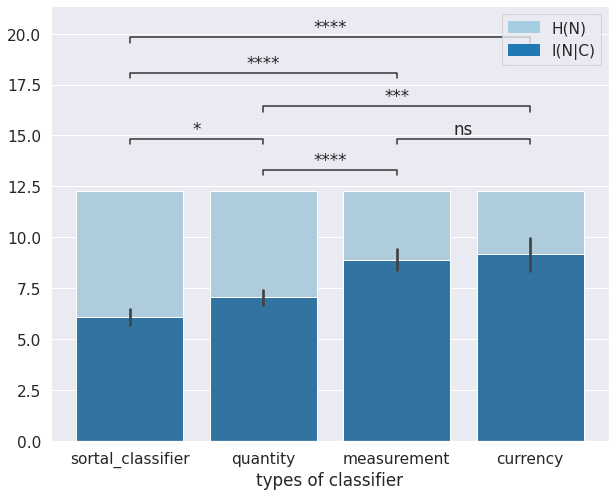

In [22]:
df_cond['per'] = (df_cond['mi']/df_cond['entropy_n'])*100
df_cond['per_100'] = 100
df_cond['per'] = round(df_cond['per'],2)


sns.set(font_scale=1.4)
ax = plt.subplots(figsize=(10, 8))

# plotting columns
ax = sns.barplot(x=df_cond["label2"], y=df_cond["entropy_n"],color='#a6cee3')
ax = sns.barplot(x=df_cond["label2"], y=df_cond["mi"], seed = 321, n_boot = 10000,color='#1f78b4')
add_stat_annotation(ax, data=df_cond, x='label2', y='mi',
                    box_pairs=[("currency", "quantity"), ("currency", "sortal_classifier"), ("measurement", "quantity"),
                               ('measurement','sortal_classifier'),('sortal_classifier','quantity'),('currency','measurement')],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
ax.set(xlabel="types of classifier", ylabel = '')

# visualizing illustration
top_bar = mpatches.Patch(color='#a6cee3', label='H(N)')
bottom_bar = mpatches.Patch(color='#1f78b4', label='I(N|C)')
plt.legend(handles=[top_bar, bottom_bar],loc='upper right')
plt.show()